# Getting Required Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 6.6 MB 45.5 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import AdamW, get_linear_schedule_with_warmup
import transformers
import torch
from torch import nn, optim
from torch.utils import data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
!pip install torchinfo
from torchinfo import summary

RANDOM_SEED = 45
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting The Data
Dataset link is [here](https://huggingface.co/datasets/winvoker/turkish-sentiment-analysis-dataset)

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/project/dataset/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/project/dataset/test.csv')
df = pd.concat([df_train, df_test], axis=0)
df = df.reset_index()
# For now I use 2000 of the 400000 sized original data because of long training time
# df = df[:2000]

In [5]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (489644, 4)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489644 entries, 0 to 489643
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   index    489644 non-null  int64 
 1   text     489644 non-null  object
 2   label    489644 non-null  object
 3   dataset  489644 non-null  object
dtypes: int64(1), object(3)
memory usage: 14.9+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


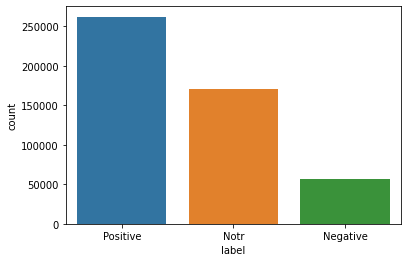

In [7]:
sns.countplot(df.label)

In [8]:
def labels_to_int(label):
    if label == 'Negative':
        return 0
    elif label == 'Positive':
        return 1
    elif label == 'Notr': 
        return 2
    else: return 0

df['label'] = df['label'].apply(labels_to_int)

In [9]:
def get_desired_labeleds(label):
  data_dict = {'text': list(), 'label': list()}
  
  if label == "negative":
    for index in range(df.shape[0]):
      if df["label"][index] ==  0:
        data_dict['text'].append(df['text'][index])
        data_dict['label'].append(df['label'][index])

  if label == "positive":
    for index in range(df.shape[0]):
      if df["label"][index] ==  1:
        data_dict['text'].append(df['text'][index])
        data_dict['label'].append(df['label'][index])

  if label == "neutral":
    for index in range(df.shape[0]):
      if df["label"][index] ==  2:
        data_dict['text'].append(df['text'][index])
        data_dict['label'].append(df['label'][index])
  
  return data_dict

pos = get_desired_labeleds("positive")
neg = get_desired_labeleds("negative")
notr = get_desired_labeleds("neutral")

In [10]:
print(len(pos['text']), len(pos['label']))
print(len(neg['text']), len(neg['label']))
print(len(notr['text']), len(notr['label']))

262166 262166
56561 56561
170917 170917


In [11]:
pos = pd.DataFrame.from_dict(pos)
neg = pd.DataFrame.from_dict(neg)
notr = pd.DataFrame.from_dict(notr)

In [72]:
df_new = pd.concat([pos[:15000], neg[:15000], notr[:15000]], axis=0)
df = df_new.reset_index()
df.shape

(45000, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


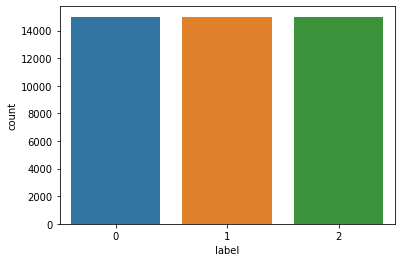

In [73]:
sns.countplot(df.label)

# Loading The Tokenizer For The Model Input 
One can load the desired model just by changing the MODEL_NAME variable.

In [74]:
MODEL_NAME = "dbmdz/electra-base-turkish-cased-discriminator"

In [75]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenizing Some Sample Text

In [76]:
sample_txt = df['text'][10]
sample_txt

'tek kelime ile harika almak isteyenlere tavsiye ederim'

In [77]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence : {sample_txt}')
print(f'Tokens   : {tokens}')
print(f'Token IDs: {token_ids}')

Sentence : tek kelime ile harika almak isteyenlere tavsiye ederim
Tokens   : ['tek', 'kelime', 'ile', 'harika', 'almak', 'isteyenlere', 'tavsiye', 'ederim']
Token IDs: [2270, 8036, 2074, 5412, 3672, 19528, 5668, 5002]


# Exploring Special Tokens

In [78]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 3)

In [79]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 2)

In [80]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [81]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 1)

# Encoding Phase

In [82]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=64,
    add_special_tokens=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
    return_token_type_ids=False
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [83]:
encoding['input_ids']

tensor([[    2,  2270,  8036,  2074,  5412,  3672, 19528,  5668,  5002,     3,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])

In [84]:
encoding['input_ids'].shape

torch.Size([1, 64])

In [85]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [86]:
encoding['attention_mask'].shape

torch.Size([1, 64])

# Determining The Sequence Length

In [87]:
token_lens = list()

for text in df.text:
    tokens = tokenizer.encode(text, max_length=512) # 512 is the max length of the BERT model
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


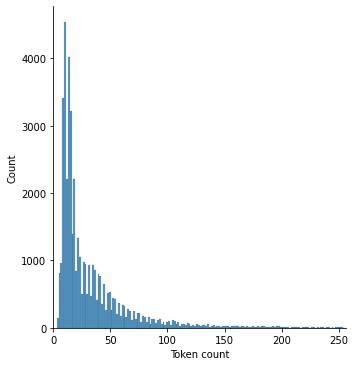

In [88]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

# Creating The Dataset

In [89]:
class Turkish_Dataset(data.Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.target = target
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])

        encoding = tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=False
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'label': torch.tensor(self.target[index], dtype=torch.long)
        }

In [91]:
MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 6

In [92]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [93]:
df_train.shape, df_val.shape, df_test.shape

((36000, 3), (4500, 3), (4500, 3))

In [94]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = Turkish_Dataset(
        text=df.text.to_numpy(),
        target=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2)

In [95]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [96]:
sample_data = next(iter(train_data_loader))
sample_data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [97]:
sample_data['input_ids'].shape # (batch_size, 1, max_len)

torch.Size([32, 1, 256])

# Model Deployment

In [98]:
model = transformers.AutoModel.from_pretrained(MODEL_NAME)
last_hidden_state = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0]
last_hidden_state

Some weights of the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[[-0.0926, -0.0694,  0.6083,  ..., -0.0686, -0.1995,  0.2824],
         [-0.0706,  0.4684,  0.2710,  ...,  0.4154,  0.0458,  0.5334],
         [ 0.0057,  0.5406, -0.0597,  ..., -0.1561,  0.3028,  0.2441],
         ...,
         [ 0.1185, -0.0076,  0.3764,  ..., -0.1193, -0.1668,  0.7135],
         [-0.0653, -0.1419,  0.6314,  ...,  0.3494, -0.2173,  0.8870],
         [ 0.0985, -0.0163,  0.3567,  ..., -0.1722, -0.0614,  0.6511]]],
       grad_fn=<NativeLayerNormBackward0>)

In [103]:
last_hidden_state.shape

torch.Size([1, 64, 768])

In [104]:
model.config.hidden_size

768

In [105]:
summary(model)

Layer (type:depth-idx)                                  Param #
ElectraModel                                            --
├─ElectraEmbeddings: 1-1                                --
│    └─Embedding: 2-1                                   24,576,000
│    └─Embedding: 2-2                                   393,216
│    └─Embedding: 2-3                                   1,536
│    └─LayerNorm: 2-4                                   1,536
│    └─Dropout: 2-5                                     --
├─ElectraEncoder: 1-2                                   --
│    └─ModuleList: 2-6                                  --
│    │    └─ElectraLayer: 3-1                           7,087,872
│    │    └─ElectraLayer: 3-2                           7,087,872
│    │    └─ElectraLayer: 3-3                           7,087,872
│    │    └─ElectraLayer: 3-4                           7,087,872
│    │    └─ElectraLayer: 3-5                           7,087,872
│    │    └─ElectraLayer: 3-6                           

In [106]:
for (name, param) in model.named_parameters():
  print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

# Creating Sentiment Model

In [107]:
class SentimentAnalyzer(nn.Module):
    def __init__(self, class_count):
        super(SentimentAnalyzer, self).__init__()
        self.model = transformers.AutoModel.from_pretrained(MODEL_NAME)
        for (name, param) in self.model.named_parameters():
          if name == "encoder.layer.11.attention.self.query.weight":
            break
          param.requires_grad = False

        self.pooler_layer = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.pooler_tanh = nn.Tanh()

        self.drop = nn.Dropout(p=0.25)
        self.output_layer = nn.Linear(self.model.config.hidden_size, class_count)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, input_ids, attention_mask):
        last_hidden_state = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        # Here I mimick the pooler implementation of classic BERT models 
        # to be able obtain required output size
        first_token_tensor = last_hidden_state[:, 0]
        pooler_output = self.pooler_layer(first_token_tensor)
        pooler_output = self.pooler_tanh(pooler_output)

        output = self.drop(pooler_output)
        output = self.output_layer(output)
        return self.sm(output)

In [108]:
!nvidia-smi

Fri Jul 29 08:41:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |   1708MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [109]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [110]:
class_names = ['Negative', 'Positive', 'Neutral']
model = SentimentAnalyzer(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
input_ids = sample_data['input_ids'].to(device)
attention_mask = sample_data['attention_mask'].to(device)

print(input_ids[:, 0, :].shape, attention_mask[:, 0, :].shape)

torch.Size([32, 256]) torch.Size([32, 256])


In [112]:
# Here I try the model w/o training
model(input_ids[:, 0, :], attention_mask[:, 0, :])

tensor([[0.4470, 0.2987, 0.2542],
        [0.3744, 0.2765, 0.3491],
        [0.4206, 0.2930, 0.2864],
        [0.3526, 0.3360, 0.3115],
        [0.4186, 0.2825, 0.2989],
        [0.4272, 0.2618, 0.3110],
        [0.4459, 0.2795, 0.2746],
        [0.3850, 0.2881, 0.3269],
        [0.3678, 0.3063, 0.3259],
        [0.4521, 0.2849, 0.2630],
        [0.3634, 0.3642, 0.2724],
        [0.3685, 0.3036, 0.3280],
        [0.3856, 0.3107, 0.3038],
        [0.4038, 0.2681, 0.3282],
        [0.4451, 0.2660, 0.2890],
        [0.4105, 0.2747, 0.3147],
        [0.3432, 0.3817, 0.2752],
        [0.4371, 0.3056, 0.2573],
        [0.4271, 0.2514, 0.3216],
        [0.3929, 0.2685, 0.3387],
        [0.4487, 0.2846, 0.2667],
        [0.3354, 0.3646, 0.3000],
        [0.4810, 0.2925, 0.2265],
        [0.3768, 0.3812, 0.2420],
        [0.3820, 0.3354, 0.2826],
        [0.4081, 0.3090, 0.2830],
        [0.3919, 0.2628, 0.3453],
        [0.4087, 0.3281, 0.2632],
        [0.4189, 0.2423, 0.3389],
        [0.358

In [113]:
summary(model)

Layer (type:depth-idx)                                       Param #
SentimentAnalyzer                                            --
├─ElectraModel: 1-1                                          --
│    └─ElectraEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (24,576,000)
│    │    └─Embedding: 3-2                                   (393,216)
│    │    └─Embedding: 3-3                                   (1,536)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─ElectraEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─Linear: 1-2                                                590,592
├─Tanh: 1-3                                                  --
├─Dropout: 1-4                                               --
├─Linear: 1-5                                              

# Training The Model

In [114]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [115]:
import time
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, num_examples):
  model = model.train()

  losses = list()
  correct_estimations = 0

  for data in data_loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    targets = data['label'].to(device)

    outputs = model(input_ids[:, 0, :], attention_mask[:, 0, :])
    # print(outputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_estimations += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  return correct_estimations.double() / num_examples, np.mean(losses)

In [116]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for data in data_loader:
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["label"].to(device)

      outputs = model(
        input_ids=input_ids[:, 0, :],
        attention_mask=attention_mask[:, 0, :]
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [117]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
----------
Train loss 0.6450305485195583 accuracy 0.9057777777777778
Val   loss 0.6131065897907771 accuracy 0.9393333333333334

Epoch 2/6
----------
Train loss 0.6168743196063572 accuracy 0.9326944444444445
Val   loss 0.6080906589825948 accuracy 0.9417777777777778

Epoch 3/6
----------
Train loss 0.6157533231841193 accuracy 0.9341666666666667
Val   loss 0.6068246246229673 accuracy 0.9433333333333334

Epoch 4/6
----------
Train loss 0.6127747129864163 accuracy 0.937138888888889
Val   loss 0.605823242072518 accuracy 0.9462222222222223

Epoch 5/6
----------
Train loss 0.6127649328443739 accuracy 0.9371944444444444
Val   loss 0.605507363241615 accuracy 0.9462222222222223

Epoch 6/6
----------
Train loss 0.6100594861772325 accuracy 0.9403611111111112
Val   loss 0.6057808471064196 accuracy 0.9453333333333334

CPU times: user 1h 14min 30s, sys: 11.1 s, total: 1h 14min 41s
Wall time: 1h 14min 44s


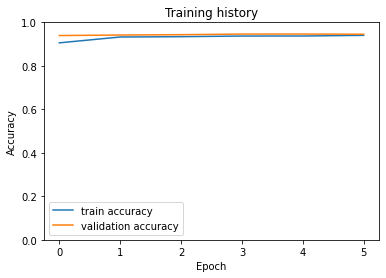

In [118]:
plt.plot([item.cpu() for item in history['train_acc']], label='train accuracy')
plt.plot([item.cpu() for item in history['val_acc']], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [119]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
print(f'Test Accuracy: {test_acc.item()}')

Test Accuracy: 0.9362222222222223


# Getting Predictions and Evaluating The Model

In [120]:
def get_predictions(model, data_loader):
  model = model.eval()
  texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for data in data_loader:
      texts = data["text"]
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["label"].to(device)

      outputs = model(
        input_ids=input_ids[:, 0, :],
        attention_mask=attention_mask[:, 0, :]
      )
      _, preds = torch.max(outputs, dim=1)
      texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return texts, predictions, prediction_probs, real_values

In [121]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [122]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.91      0.91      0.91      1477
    Positive       0.91      0.91      0.91      1554
     Neutral       0.99      1.00      0.99      1469

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500



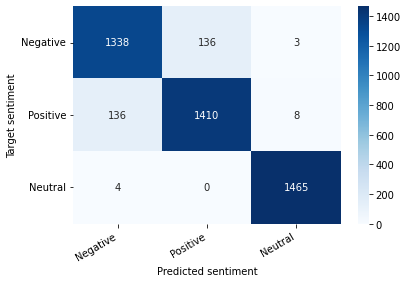

In [123]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Target sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Raw Text Prediction


In [127]:
sample_texts = ["Bu proje üzerine çalışmak eğlenceli", 
                "Bazen hayat onun için dayanılmaz acılarla dolu bir yer haline geliyordu.", 
                "Bunun iyi çalışan bir model olup olmadığı konusunda bazı şüpheleri vardı.",
                "Hiç güzel bir uygulama olmamış, hiçbir isteğimizi karşılamıyor.",
                "kötü"]

In [128]:
encoded_texts = list()

for sample_text in sample_texts:
  encoded_text = tokenizer.encode_plus(
    sample_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )
  encoded_texts.append(encoded_text)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [130]:
for i in range(len(sample_texts)):
  input_ids = encoded_texts[i]['input_ids'].to(device)
  attention_mask = encoded_texts[i]['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print(f'Sample text: {sample_texts[i]}')
  print(f'Sentiment  : {class_names[prediction]}')

Sample text: Bu proje üzerine çalışmak eğlenceli
Sentiment  : Positive
Sample text: Bazen hayat onun için dayanılmaz acılarla dolu bir yer haline geliyordu.
Sentiment  : Neutral
Sample text: Bunun iyi çalışan bir model olup olmadığı konusunda bazı şüpheleri vardı.
Sentiment  : Neutral
Sample text: Hiç güzel bir uygulama olmamış, hiçbir isteğimizi karşılamıyor.
Sentiment  : Negative
Sample text: kötü
Sentiment  : Positive
